In [1]:
import numpy as np
import pandas as pd
import os
import re

# Data Prep for Model

In [2]:
state_level_df = pd.read_csv('data/cln/selected_states_real_sir.csv')
state_level_df[['state','population']].drop_duplicates()

state_level_df['standardized_date'] = pd.to_datetime(state_level_df['standardized_date'])
start_date_df = state_level_df.groupby(['state'],as_index = False).agg({'standardized_date':'min'})
start_date_df.columns = ['state','start_date']

state_level_df = pd.merge(state_level_df,start_date_df)
state_level_df['day'] = state_level_df['standardized_date'] - state_level_df['start_date']
state_level_df['day'] = state_level_df['day'].apply(lambda x : x.days)
state_level_df[state_level_df['day'] == 0]

,state,standardized_date,# Infected,# Deaths,total_number_of_days,population,# Susceptible,start_date,day
0,CA,2020-02-21,10.0,0.0,46,37253956,37253946.0,2020-02-21,0
47,CT,2020-03-14,20.0,0.0,24,3574097,3574077.0,2020-03-14,0
72,FL,2020-03-09,14.0,2.0,29,18801310,18801296.0,2020-03-09,0
102,IL,2020-03-09,13.0,0.0,29,12830632,12830619.0,2020-03-09,0
132,LA,2020-03-11,13.0,0.0,27,4533372,4533359.0,2020-03-11,0
160,MA,2020-03-08,22.0,0.0,30,6547629,6547607.0,2020-03-08,0
191,MI,2020-03-12,12.0,0.0,26,9883640,9883628.0,2020-03-12,0
218,NY,2020-03-04,11.0,0.0,34,19378102,19378091.0,2020-03-04,0
253,WA,2020-03-01,11.0,1.0,37,6724540,6724529.0,2020-03-01,0


In [3]:
state_level_df.columns=['Region name', 'date','# Infected','# Removed', 'total_number_of_days', 
                        'population','# Susceptible','start_date','day']
test_data = state_level_df[['Region name', 'date','# Infected','# Removed','# Susceptible','day']].copy()

test_data.head(3)

,Region name,date,# Infected,# Removed,# Susceptible,day
0,CA,2020-02-21,10.0,0.0,37253946.0,0
1,CA,2020-02-22,10.0,0.0,37253946.0,1
2,CA,2020-02-23,10.0,0.0,37253946.0,2


In [4]:
total_day_state = state_level_df[['Region name', 'total_number_of_days']].drop_duplicates()
total_day_state

,Region name,total_number_of_days
0,CA,46
47,CT,24
72,FL,29
102,IL,29
132,LA,27
160,MA,30
191,MI,26
218,NY,34
253,WA,37


# Model Starts here


In [5]:
from src.eval_model import *
from src.SEIR_bjc import seir_bjc, dynamic_sim_seir_bjc, dynamic_sim_seir_bjc_df

In [6]:
# get the day 0's number

DAY_0 = test_data[test_data['day'] == 0].copy()

DAY_0['N'] = DAY_0['# Infected'] + DAY_0['# Susceptible'] + DAY_0['# Removed']

DAY_0

,Region name,date,# Infected,# Removed,# Susceptible,day,N
0,CA,2020-02-21,10.0,0.0,37253946.0,0,37253956.0
47,CT,2020-03-14,20.0,0.0,3574077.0,0,3574097.0
72,FL,2020-03-09,14.0,2.0,18801296.0,0,18801312.0
102,IL,2020-03-09,13.0,0.0,12830619.0,0,12830632.0
132,LA,2020-03-11,13.0,0.0,4533359.0,0,4533372.0
160,MA,2020-03-08,22.0,0.0,6547607.0,0,6547629.0
191,MI,2020-03-12,12.0,0.0,9883628.0,0,9883640.0
218,NY,2020-03-04,11.0,0.0,19378091.0,0,19378102.0
253,WA,2020-03-01,11.0,1.0,6724529.0,0,6724541.0


## SEIR_bjc: Find best $\beta$, E0, hospital prop


### fix $\sigma$, $\gamma_r$, $\gamma_h$, $\psi$

In [7]:
sigma = 1/5
gamma_r = 1/7
gamma_h = 1/7
psi = 1/10

In [8]:
beta_range = np.arange(1e-8, 5.05e-7, 5e-9)
E_adjust_range = np.array([0.5, 1, 1.5, 2, 5]) ## Exposed population as percent of Infected
hosp_prop_range = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3]) ## hospitalization rate

In [9]:
def print_range(txt, x):
    print(txt + ' : ' + str(min(x)) + ' - ' + str(max(x)) + ' (' + str(len(x)) + ')')

In [10]:
print_range("beta_range", beta_range)
print_range('E_adjust_range', E_adjust_range)
print_range('hosp_prop_range', hosp_prop_range)

beta_range : 1e-08 - 5.000000000000002e-07 (99)
E_adjust_range : 0.5 - 5.0 (5)
hosp_prop_range : 0.05 - 0.3 (6)


In [11]:
beta_v, E_v, hosp_prop_v = np.meshgrid(
    beta_range, \
    E_adjust_range, \
    hosp_prop_range, \
    sparse = False)

Grid = pd.DataFrame({
    'beta': beta_v.flatten(),
    'E_adjust': E_v.flatten(),
    'hosp_prop': hosp_prop_v.flatten()
})

In [12]:
Grid.shape

(2970, 3)

In [13]:
# grid search for each region

region_var = 'Region name'
n_days_eval = 5 # carve out 5 days for back test

for region in test_data[region_var].unique():
    
    print(region)
    
    simulation_results = pd.DataFrame()
    
    for index, row in Grid.iterrows(): 
        
        N =  DAY_0.loc[DAY_0[region_var] == region,'N'].tolist()[0]
        R =  DAY_0.loc[DAY_0[region_var] == region,'# Removed'].tolist()[0]
        I =  DAY_0.loc[DAY_0[region_var] == region,'# Infected'].tolist()[0]
                
        # assume H0, D0 are all zero
        H = 0
        D = 0
                            
        # Exposed
        E =  int(row['E_adjust'] * I)
                
        # back calculcate S
        S = N - I - R - E
                
        # use part of days to do grid search
        n_days = total_day_state.loc[total_day_state[region_var] == region, 
                                     'total_number_of_days'].tolist()[0] - n_days_eval
            
        tmp, tmp2 = dynamic_sim_seir_bjc_df(S, E, I, R, H, D,
                                            sigma, row['hosp_prop'], gamma_r, gamma_h, psi, 
                                            0, 
                                            [row['beta']] * n_days, n_days)
        report = tmp.copy()
        report[region_var] = region
        
        # include parameter setting
        report['E0'] = E
        report['hosp_prop'] = row['hosp_prop']
        report['beta'] = row['beta']
                
        # append
        simulation_results = simulation_results.append(report)
    
    simulation_results = pd.merge(simulation_results, test_data, on = [region_var, 'day'])
    
    print(simulation_results.shape)

    simulation_results.to_csv('result/seir_bjc/grid/' + region + '.csv', index = False)


CA
(124740, 14)
CT
(59400, 14)
FL
(74250, 14)
IL
(74250, 14)
LA
(68310, 14)
MA
(77220, 14)
MI
(65340, 14)
NY
(89100, 14)
WA
(98010, 14)


In [14]:
best_param = pd.DataFrame()
grid_path = 'result/seir_bjc/grid/'

for path in os.listdir(grid_path):
    
    if re.findall(".csv", path):
    
        region = re.sub(".csv", "", path)
    
        data = pd.read_csv(grid_path + path)
    
        data = data.groupby(['E0', 'hosp_prop', 'beta']).\
        apply(lambda x: gen_Metrics(x, 'infected', '# Infected')).\
        reset_index().\
        drop('level_3', axis = 1)
    
        tmp = data.loc[data['SSE'].idxmin()].copy() ## min
    
        tmp[region_var] = region
    
        best_param = best_param.append(tmp)

best_param.to_excel(grid_path + '_best_param.xlsx', index = False)

In [15]:
best_param

,E0,Region name,SAE,SAPE,SSE,SSPE,beta,hosp_prop
2692,55.0,WA,17105.625472,12.526187,1.444993e+07,6.172820,1.050000e-07,0.20
2832,100.0,CT,3666.995769,3.774027,1.553689e+06,0.956189,3.100000e-07,0.25
2898,60.0,MI,16991.299446,7.739807,2.448041e+07,3.768074,1.450000e-07,0.30
2476,50.0,CA,9815.307743,49.817912,6.011844e+06,152.415326,1.500000e-08,0.10
2484,70.0,FL,11081.587954,6.217823,1.100109e+07,1.989203,5.500000e-08,0.10
2885,65.0,IL,11402.900540,7.006126,1.051468e+07,2.535802,8.000000e-08,0.30
2428,65.0,LA,8635.281488,7.420207,5.745324e+06,3.199256,2.700000e-07,0.05
2896,110.0,MA,6357.649501,4.758100,3.831473e+06,1.267225,1.350000e-07,0.30
2093,22.0,NY,275164.284595,16.182286,6.105693e+09,10.043347,8.000000e-08,0.20


# Final Model

In [16]:
region_var = 'Region name'
best_param_2 = pd.read_excel('result/seir_bjc/grid/_best_param.xlsx')
final_result = pd.DataFrame()

for region in DAY_0[region_var]:
    
    # fixed
    N =  DAY_0.loc[DAY_0[region_var] == region,'N'].tolist()[0]
    R =  DAY_0.loc[DAY_0[region_var] == region,'# Removed'].tolist()[0]
    I =  DAY_0.loc[DAY_0[region_var] == region,'# Infected'].tolist()[0]
    
    # best SIRX
    E = best_param_2.loc[best_param_2[region_var] == region, 'E0'].tolist()[0]
    beta = best_param_2.loc[best_param_2[region_var] == region, 'beta'].tolist()[0]
    hosp_prop = best_param_2.loc[best_param_2[region_var] == region, 'hosp_prop'].tolist()[0]

    # assume H0, D0 are all zero
    H = 0
    D = 0
        
    S = N - I - R - E
                
    # use all available days
    n_days = total_day_state.loc[total_day_state[region_var] == region, 
                                 'total_number_of_days'].tolist()[0]
            
    tmp, tmp2 = dynamic_sim_seir_bjc_df(S, E, I, R, H, D,
                                     sigma, hosp_prop, gamma_r, gamma_h, 
                                     psi, 0, 
                                     [beta] * n_days, n_days)
    report = tmp.copy()
    report[region_var] = region
                
    # append
    report['day'] = report.index.astype(int)
    final_result = final_result.append(report)


final_result.to_excel('result/seir_bjc/final_seir_bjc_model.xlsx', index = False)

# Plot the curve

In [17]:
final_result_sir = pd.read_excel('result/sir/final_sir_model.xlsx')\
[['susceptible', 'infected', 'recovered', 'Region name', 'day']].\
rename(columns = {'susceptible':'SIR # Susceptible',
                 'infected':'SIR # Infected',
                 'recovered':'SIR # Removed'})

final_result_seir = pd.read_excel('result/seir_bjc/final_seir_bjc_model.xlsx')\
[['susceptible', 'infected', 'recovered', 'Region name', 'day']].\
rename(columns = {'susceptible':'SEIR-bjc # Susceptible',
                 'infected':'SEIR-bjc # Infected',
                 'recovered':'SEIR-bjc # Removed'})

In [18]:
final = pd.merge(final_result_sir, final_result_seir)
final = pd.merge(final, test_data)

In [19]:
min_date = min(final['date'])
max_date = max(final['date'])

min_y = min(min(final.loc[final['Region name'].isin(['NY', 'MI']) == False, 'SEIR-bjc # Infected']),
            min(final.loc[final['Region name'].isin(['NY', 'MI']) == False, 'SIR # Infected']), 
            min(final.loc[final['Region name'].isin(['NY', 'MI']) == False, '# Infected']))

max_y = max(max(final.loc[final['Region name'].isin(['NY', 'MI']) == False, 'SEIR-bjc # Infected']), 
            max(final.loc[final['Region name'].isin(['NY', 'MI']) == False, 'SIR # Infected']), 
            max(final.loc[final['Region name'].isin(['NY', 'MI']) == False, '# Infected']))
nrow = 3
ncol = 3

x = np.arange(0, nrow, 1)
y = np.arange(0, ncol, 1)
xx, yy = np.meshgrid(x, y)    
num = 0 

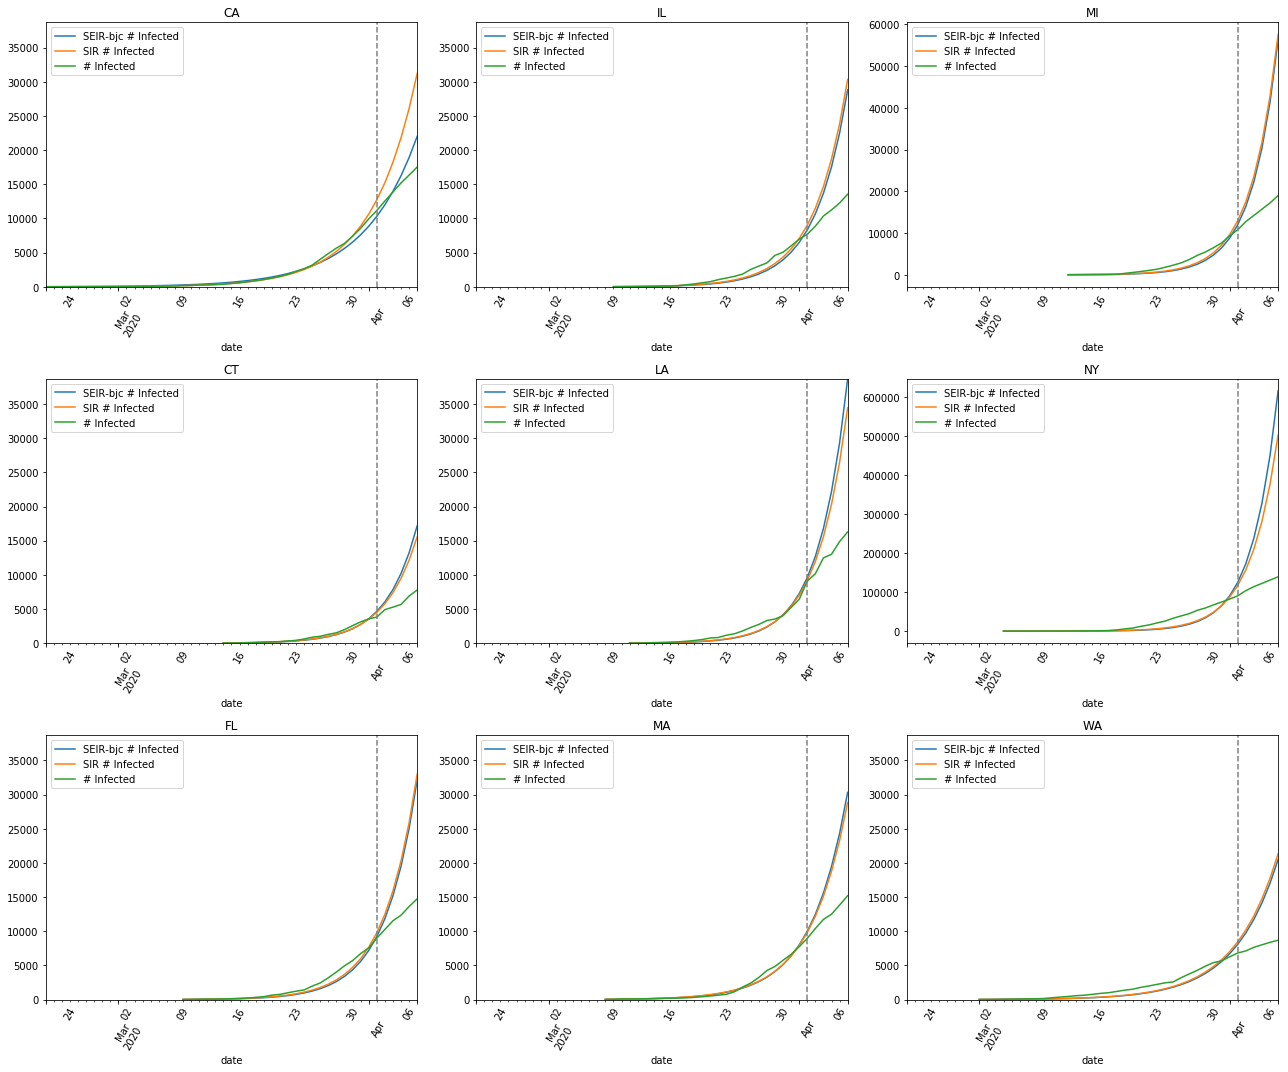

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = nrow, ncols = ncol, figsize = (ncol * 6, nrow * 5))

for region in final['Region name'].unique():
    
    
    region_data = final[final['Region name'] == region].copy()
    
    # find the last day for gridsearch
    end_day = total_day_state.loc[total_day_state['Region name'] == region, "total_number_of_days"].tolist()[0] - 5
   
    end_date = pd.to_datetime(region_data.loc[region_data['day'] == end_day, "date"].tolist()[0])
    
    # axis set up 
    x = xx.flatten()[num]
    y = yy.flatten()[num]
            
    # plot
    tmp = region_data[['date', 'SEIR-bjc # Infected', 'SIR # Infected', '# Infected']].copy()
    
    tmp['date'] = tmp['date'].apply(lambda x: pd.to_datetime(x))
    
    tmp = tmp.set_index('date')
    
    if region in ['NY', 'MI']:
        ax = tmp.plot(ax = axes[x, y], title = region, rot = 60, xlim = (min_date, max_date))
    else:
        ax = tmp.plot(ax = axes[x, y], title = region, rot = 60, xlim = (min_date, max_date), ylim = (min_y, max_y))

    ax.axvline(end_date, color="grey", linestyle="--")
    
    num += 1

plt.tight_layout()
plt.savefig('result/seir_bjc//final_fitted_seir_bjc.png', dpi = 220)